# Evalutation and plots
This Notebook is used to generate the main plots fore evaluation

In [2]:
from hydrostats import ens_metrics
from itertools import product
from models.loss import crps_averaged, crps_no_avg
from scipy.stats import norm
from utils.data import load_dataframes, load_distances
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmasher as cmr
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

plt.style.use('default')
plt.rcParams.update({'font.size': 12})
# Latex rendering (comment out if not installed)
#plt.rcParams.update({'text.usetex': True,
#                     'font.family': 'Computer Modern Roman',
#                     'text.latex.preamble': r'\usepackage{amsmath} \usepackage{siunitx}'})

In [2]:
#import tikzplotlib # Use this to save tikz files (does not work all the time)
# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)

## Helper Functions

In [3]:
# Function to coler different time horizons differently
def get_color(name):
    if "24h" in name:
        return cmr.get_sub_cmap(cmr.swamp,0.3,0.8)
    elif "72h" in name:
        return cmr.get_sub_cmap(cmr.freeze,0.3,0.8)
    elif "120h" in name:
        return cmr.get_sub_cmap(cmr.flamingo,0.3,0.8)
    else:
        return cmr.get_sub_cmap(cmr.amber,0.3,0.8)

## Gather Results
In the following, the results are loaded and the crps is calculated

In [4]:
FOLDER = "trained_models"
MODEL = "best_24h"
PATH = os.path.join(FOLDER, MODEL)
DATASET = "f"

predictions = pd.read_csv(os.path.join(PATH, f"{DATASET}_results.csv"))
predictions = predictions.dropna(axis=0)

y = torch.tensor(predictions["t2m"].to_numpy())
preds = torch.tensor(predictions[["mu", "sigma"]].to_numpy())

### CRPS calculation
Compute the average CRPS over all observations in the test set

$$\operatorname{CRPS}(F,y) = \frac{1}{n_{obs}}\sum^{n_{obs}}_{i=1}\int_{-\infty}^{\infty}(F(z)-\mathbb{I}_{y\leq z})^2\,dz$$


In [5]:
y = predictions["t2m"].to_numpy()
mu = predictions["mu"].to_numpy()
sigma = predictions["sigma"].to_numpy()

err = crps_averaged(mu_sigma=torch.tensor(predictions[["mu", "sigma"]].to_numpy()), y=torch.tensor(predictions["t2m"].to_numpy())).item()
err

0.5953938072523755

## Save Averaged Results to common DataFrame
The result loaded above is now put into a common dataframe, averaged per temperature range.  
This has to be repeated for all the models you want to compare to each other.

### Average CRPS

In [6]:
crps_per_obs = crps_no_avg(preds.cpu(), torch.tensor(y)).flatten().numpy()
# Assuming you have the numpy arrays crps_per_obs and y
# Create bins for y values from -10 to 20 with a step of 0.5
y_bins = np.arange(-19, y.max()+0.5, 1)

# Use digitize to assign each y value to its corresponding bin
y_bin_indices = np.digitize(y, y_bins)

# Initialize an array to store the average crps_per_obs for each bin
average_crps = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_crps[i - 1] = np.mean(crps_per_obs[mask])

# Save for multiline plot
df = pd.read_csv(f'figures/meanCRPSVsTemp_{DATASET}.csv')
df[f"Average_CRPS_{MODEL}"] = average_crps
df.to_csv(f'figures/meanCRPSVsTemp_{DATASET}.csv', index=False)

### Average Sigma (predicted uncertainty)

In [7]:
sigma = predictions["sigma"].to_numpy()
# Initialize an array to store the average crps_per_obs for each bin
average_sigma = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_sigma[i - 1] = np.mean(sigma[mask])

# Save for multiline plot
df = pd.read_csv(f'figures/meanSigmaVsTemp_{DATASET}.csv')
df[f"Average_SD_{MODEL}"] =  average_sigma
df.to_csv(f'figures/meanSigmaVsTemp_{DATASET}.csv', index=False)

## More Plots

Text(0.5, 1.0, 'CRPS=0.5954')

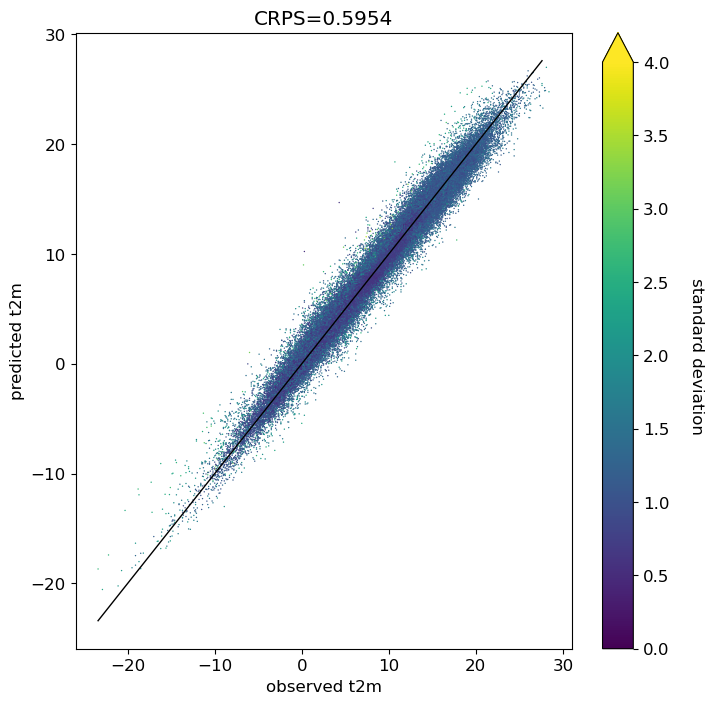

In [8]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=4, rasterized=True)

cbar = plt.colorbar(extend='max')
cbar.set_label('standard deviation', rotation=270, labelpad=25)
plt.xlabel(r'observed t2m')
plt.ylabel('predicted t2m')
plt.title(f"CRPS={err:.4f}")
#plt.savefig(f"figures/predsObs_{MODEL}_{DATASET}.pdf", format='pdf', dpi=600, bbox_inches='tight')
#tikzplotlib.save(f"figures/predsObs_{MODEL}_{DATASET}.tex")

Text(0.5, 0, 'PIT value')

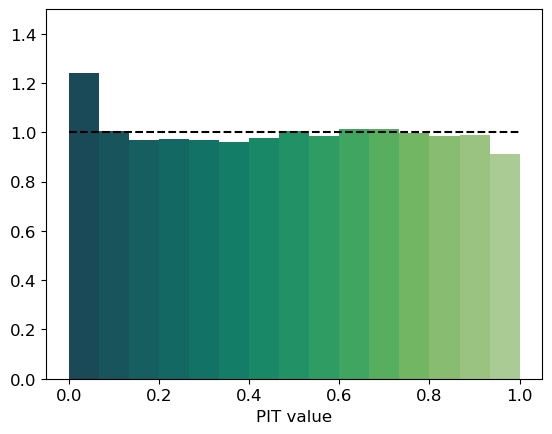

In [9]:
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=15, density=True)

# colors
cm = get_color(MODEL)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))


plt.ylim(0,1.5)  # Layout
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT value')
#plt.savefig(f"figures/PIT_{MODEL}_{DATASET}.pdf", format='pdf', dpi=300, bbox_inches='tight')
#tikzplotlib.save(f"figures/PIT_{MODEL}_{DATASET}.tex")

## Summary plots of all models
### Temperature vs. mean CRPS for both Tasks *R2R* and *R2F*

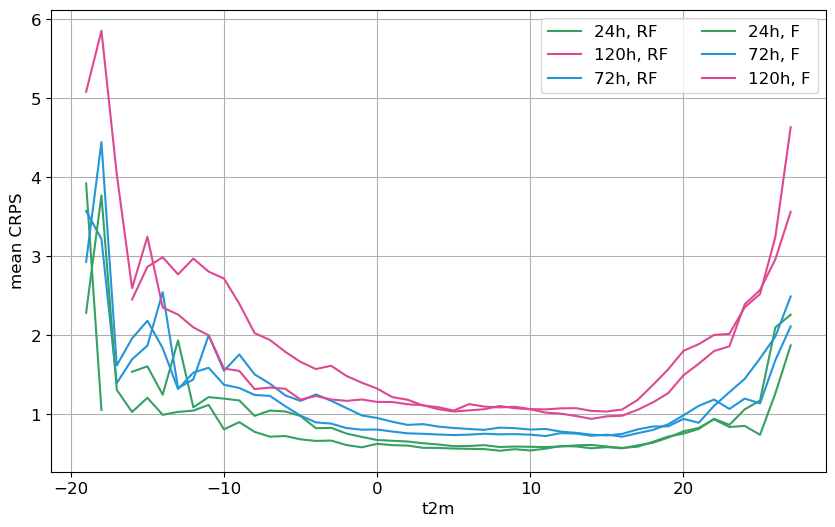

In [10]:
# Create a line plot
df_rf = pd.read_csv('figures/meanCRPSVsTemp_rf.csv')
df_f = pd.read_csv('figures/meanCRPSVsTemp_f.csv')

df_rf.rename(columns={"Average_CRPS_best_24h": "24h, RF",
                      "Average_CRPS_best_72h":"72h, RF",
                      "Average_CRPS_best_120h": "120h, RF"}, inplace=True)
df_f.rename(columns={"Average_CRPS_best_24h": "24h, F",
                      "Average_CRPS_best_72h":"72h, F",
                      "Average_CRPS_best_120h": "120h, F"}, inplace=True)


df = pd.merge(df_rf, df_f, on="temp")
df.iloc[:, 1:] = df.iloc[:,1:].replace(0, np.nan)


#df = df[(df != 0).all(axis=1)] # Remove rows with all zeros -> no data available
y_bins = df.temp

plt.figure(figsize=(10, 6))
for col in df.columns[1:]:
    plt.plot(y_bins, df[col], label=col, color=get_color(col)(0.6), ls='-')# if "RF" in col else '--', linewidth=1)
plt.xlabel('t2m')
plt.ylabel('mean CRPS')
plt.legend(fontsize=12,ncol=2)
plt.grid()
#tikzplotlib_fix_ncols(plt.gca())
#plt.savefig(f"figures/meanCRPSVsTemp_all.pdf", format='pdf', dpi=300, bbox_inches='tight')
#tikzplotlib.save(f"figures/meanCRPSVsTemp_all.tex")

### Temperature vs. mean $\sigma$ for both Tasks *R2R* and *R2F*

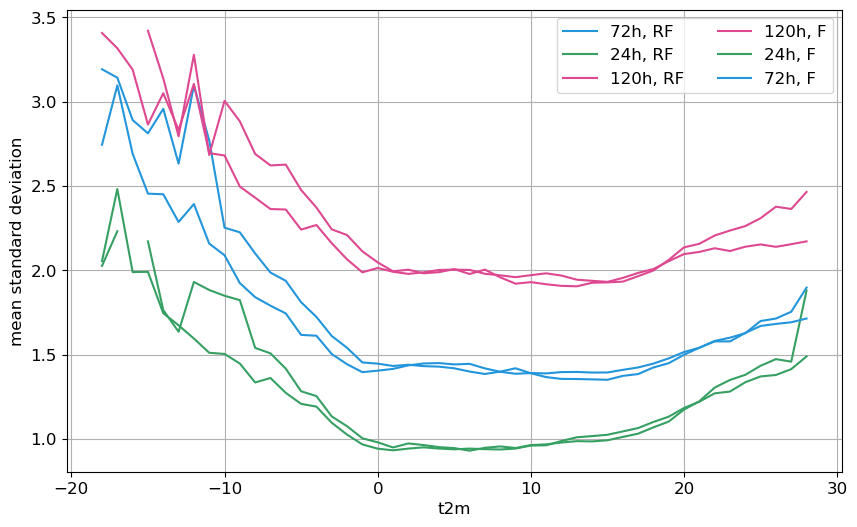

In [11]:
# Create a line plot
df_rf = pd.read_csv('figures/meanSigmaVsTemp_rf.csv')
df_f = pd.read_csv('figures/meanSigmaVsTemp_f.csv')

df_rf.rename(columns={"Average_SD_best_24h": "24h, RF",
                      "Average_SD_best_72h":"72h, RF",
                      "Average_SD_best_120h": "120h, RF"}, inplace=True)
df_f.rename(columns={"Average_SD_best_24h": "24h, F",
                      "Average_SD_best_72h":"72h, F",
                      "Average_SD_best_120h": "120h, F"}, inplace=True)


df = pd.merge(df_rf, df_f, on="temp")
df.iloc[:, 1:] = df.iloc[:,1:].replace(0, np.nan)


#df = df[(df != 0).all(axis=1)] # Remove rows with all zeros -> no data available
y_bins = df.temp

plt.figure(figsize=(10, 6))
for col in df.columns[1:]:
    plt.plot(y_bins, df[col], linestyle='-', label=col, color=get_color(col)(0.6))
plt.xlabel('t2m')
plt.ylabel('mean standard deviation')
plt.legend(fontsize=12, ncol=2)
plt.grid()
#plt.savefig(f"figures/SDVsTemp_all.pdf", format='pdf', dpi=300, bbox_inches='tight')
#tikzplotlib_fix_ncols(plt.gca())
#tikzplotlib.save(f"figures/SDVsTemp_all.tex")

## All 3 PIT Plots next to each other

Probability integral transform: evaluate each observation at the CDF of the predicted distributiion.  
The results should follow a uniform distribution if the model producing the predicted distributions is accurate.
Since we predict normal distributions, $\Phi$ can be used to describe the CDF.

$$\text{PIT: } F(y) =  \phi(\frac{y-\mu}{\sigma})$$

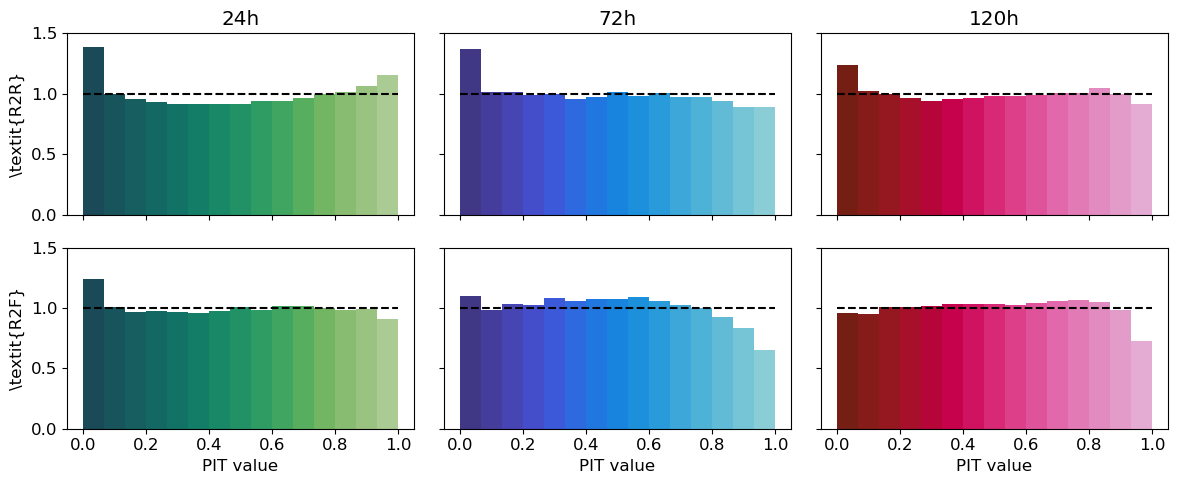

In [12]:
FOLDER = "trained_models"
MODELS = ["best_24h", "best_72h", "best_120h"]
DATASET = ["rf", "f"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=True)  # Shared x and y axes

# Loop through each dataset
for i, d in enumerate(DATASET):
    for j, m in enumerate(MODELS):
        ax = axes[i, j]  # Get the subplot for this combination

        PATH = os.path.join(FOLDER, m)
        predictions = pd.read_csv(os.path.join(PATH, f"{d}_results.csv"))
        predictions = predictions.dropna(axis=0)
        y = predictions["t2m"].to_numpy()
        mu = predictions["mu"].to_numpy()
        sigma = predictions["sigma"].to_numpy()

        # Calc Z values
        probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
        n, bins, patches = ax.hist(probs, bins=15, density=True)

        # colors
        cm = get_color(m)  # Assuming MODEL is defined somewhere in your code
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= (max(col))

        for c, p in zip(col, patches):
            p.set_facecolor(cm(c))

        ax.set_ylim(0, 1.5)  # Layout
        ax.hlines(y=1, xmin=0, xmax=1, colors="black", linestyles="--")
        if i == 0:
            #ax.set_title(r"\SI{24}{\hour}" if m == "best_24h" else r"\SI{72}{\hour}" if m == "best_72h" else r"\SI{120}{\hour}")
            ax.set_title("24h" if "24h" in m else "72h" if "72h" in m else "120h")
        if i == 1:
            ax.set_xlabel('PIT value')
        if j == 0:
            ax.set_ylabel(r'\textit{R2R}' if d == "rf" else r'\textit{R2F}')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
#plt.savefig(f"figures/PIT_all.pdf", format='pdf', dpi=300, bbox_inches='tight')
#tikzplotlib.save("figures/PIT_all_DRN.tex")

# PIT of Raw Ensemble
Estimate a Normal distribution from the ensemble prediction and apply standard PIT prcedure

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.data import load_dataframes, summary_statistics
#plt.rcParams.update({"font.size": 18})

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


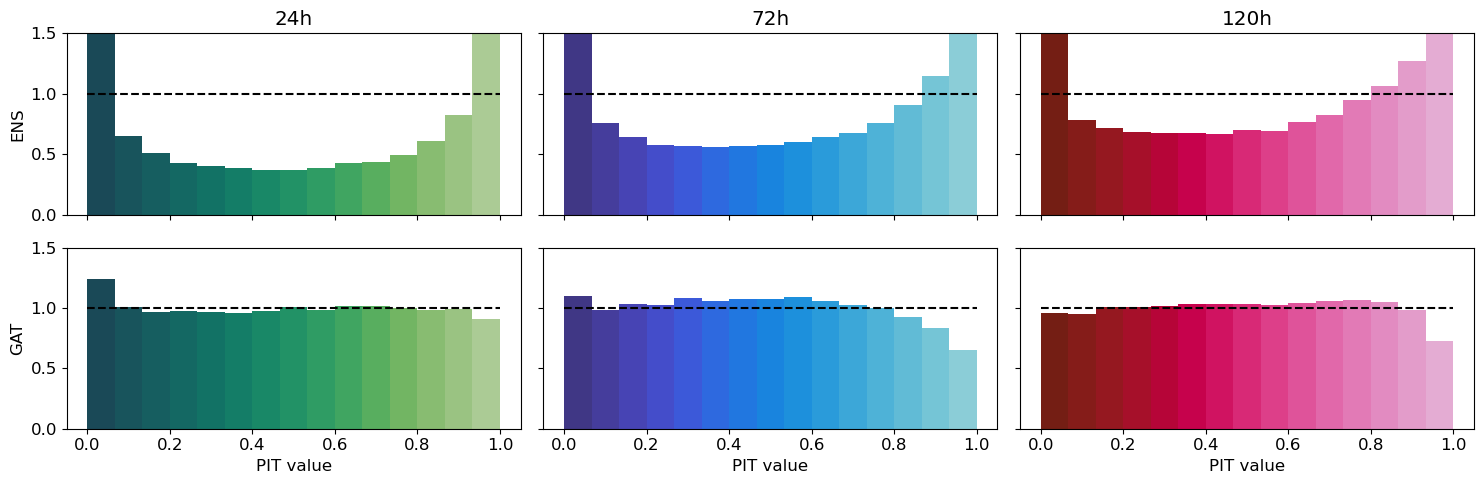

In [14]:
LEADTIME = ["24h", "72h", "120h"]
DATASET = "f"
Model = ["raw", "best"]
FOLDER = "trained_models"

# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), sharex=True, sharey=True)  # Shared x and y axes

for j, l in enumerate(LEADTIME):
    for i, m in enumerate(Model):
        ax = axes[i, j]  # Get the subplot for this combination

        if m == "raw":
            dataframes = load_dataframes(mode="train", leadtime=l)
            dataframes = summary_statistics(dataframes)
            mu = dataframes[f'test_{DATASET}'][0][["t2m_mean"]].to_numpy()
            sigma = dataframes[f'test_{DATASET}'][0][["t2m_std"]].to_numpy()
            y = dataframes[f'test_{DATASET}'][1]["t2m"].to_numpy()
        else:
            PATH = os.path.join(FOLDER, "_".join([m, l]))
            predictions = pd.read_csv(os.path.join(PATH, f"{d}_results.csv"))
            predictions = predictions.dropna(axis=0)
            y = predictions["t2m"].to_numpy()
            mu = predictions["mu"].to_numpy()
            sigma = predictions["sigma"].to_numpy()

            

        # Calc Z values
        probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
        n, bins, patches = ax.hist(probs, bins=15, density=True)

        # colors
        cm = get_color(l)  # Assuming MODEL is defined somewhere in your code
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= (max(col))

        for c, p in zip(col, patches):
            p.set_facecolor(cm(c))

        ax.set_ylim(0, 1.5)  # Layout
        ax.hlines(y=1, xmin=0, xmax=1, colors="black", linestyles="--")
        if i == 0:
            ax.set_title(l)
        if i == 1:
            ax.set_xlabel('PIT value')
        if j == 0:
            ax.set_ylabel(r'GAT' if m == "best" else r'ENS')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
#plt.savefig(f"figures/PIT_GATvsENS.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Permutation Importance
Plot of Permutation Importance, clalculated by comparing the score of an unshuffled feature set with one where the ith feature is shuffled.

In [15]:
DATASET = "f"

models = ["best_24h", "best_72h", "best_120h"]


dfs = []
for model in models:
    df = pd.read_csv(f"trained_models/{model}/permutation_importance_{DATASET}.csv")
    df["lead_time"] = model.split("_")[1]
    dfs.append(df)
df = pd.concat(dfs, axis=0)
df.reset_index(drop=True, inplace=True)

# Rename long names
df.rename(columns={"station_id": "id",
                   "model_orography": "orog",
                   "station_altitude": "alt",
                   "station_latitude": "latitude",
                   "station_longitude": "lon",
                   "transformed_time": "time"
                   }, inplace=True)

# Importance
for column in df.columns.difference(["lead_time", "no_permutation"]):
    df[column] = (df[column] - df["no_permutation"]) / df["no_permutation"]
df.drop(columns=["no_permutation"], inplace=True)

def normalize_category(group):
    group = group / group.mean().sum()
    return group

df = df.groupby("lead_time").apply(normalize_category).reset_index().drop(columns=["level_1"])

# Save Leadtime
leadtime = df["lead_time"].copy()
df.drop(columns=["lead_time"], inplace=True)
# Sort by mean importance
keys = df.mean(axis=0).sort_values(ascending=False).index
df = df.loc[:,keys]
df["lead_time"] = leadtime

df = pd.melt(df, id_vars=["lead_time"], var_name="feature", value_name="importance")

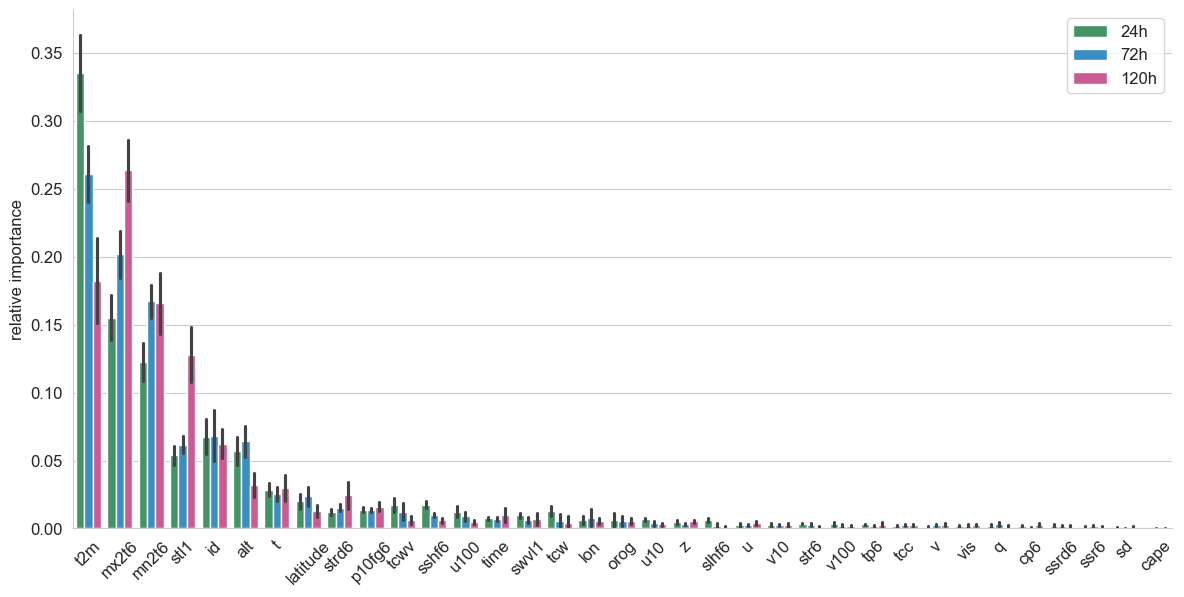

In [16]:
sns.set_style("whitegrid")
c = [get_color(lead_time)(0.6) for lead_time in ["24h", "72h", "120h"]]

g = sns.catplot(data=df, kind="bar",
                x="feature", y="importance", hue="lead_time", hue_order=["24h", "72h", "120h"],
                errorbar="sd", palette=c, height=6, aspect=2,
                legend_out=None)
g.set_axis_labels("", "relative importance")
g.legend.set_title("")

g.set(ylim=(0, None))

# Rotate x-axis labels by 45 degrees
g.set_xticklabels(rotation=45)

# Save
#tikzplotlib_fix_ncols(g.ax)
#tikzplotlib.save(f"figures/PI_{DATASET}.tex")

## DRN vs. GAT improvement
Stationwise improvement of GAT over DRN, measured bs CRPSS.

In [17]:
LEADTIME = "24h"
DATASET = "f"

model1 = pd.read_csv(f"trained_models/best_{LEADTIME}/{DATASET}_results.csv")
model1["t2m"] = model1["t2m"] + 273.15
model1["mu"] = model1["mu"] + 273.15

model2 = pd.read_csv(f"trained_models/drn_{LEADTIME}/{DATASET}_results.csv")
dfs = load_dataframes(mode="eval", leadtime=LEADTIME)
targets = dfs[f"test_{DATASET}"][1].dropna(axis=0) # Needed for Station ID

[INFO] Dataframes exist. Will load pandas dataframes.


In [18]:
# Get CRPS per station
targets["crps_GAT"] = crps_no_avg(torch.tensor(model1[["mu", "sigma"]].to_numpy()), torch.tensor(model1["t2m"].to_numpy())).flatten().numpy()
targets["crps_DRN"] = crps_no_avg(torch.tensor(model2[["mu", "sigma"]].to_numpy()), torch.tensor(model2["t2m"].to_numpy())).flatten().numpy()
station_crps = targets.groupby("station_id")[["crps_GAT", "crps_DRN"]].mean().reset_index()

/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_55347/2976784932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets["crps_GAT"] = crps_no_avg(torch.tensor(model1[["mu", "sigma"]].to_numpy()), torch.tensor(model1["t2m"].to_numpy())).flatten().numpy()
/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_55347/2976784932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets["crps_DRN"] = crps_no_avg(torch.tensor(model2[["mu", "sigma"]].to_numpy()), torch.tensor(model2["t2m"].to_

In [19]:
station_crps["crpss"] = 1 - (station_crps["crps_GAT"] / station_crps["crps_DRN"])
stations = dfs["stations"]
stations["station_id"] = np.arange(0, len(stations))
stations = pd.merge(left=stations, right=station_crps, on="station_id")

In [20]:
class MidpointNormalize(mpl.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

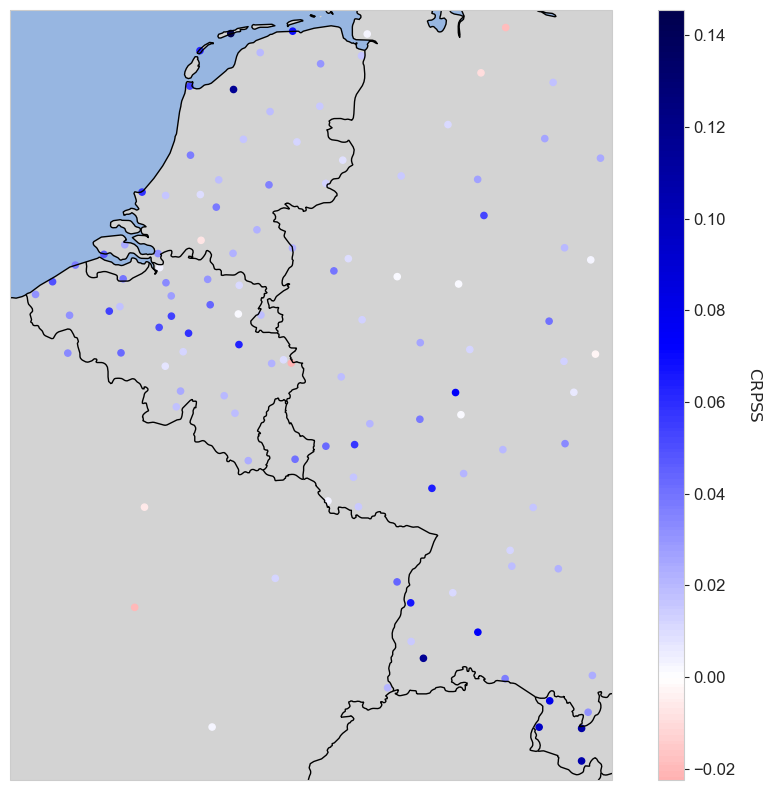

In [21]:
#plt.rcParams.update({'font.size': 20})

cmap = "seismic_r"
norm = MidpointNormalize(midpoint=0)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

ax.set_ylim(46.8, 53.6)
ax.set_xlim(2.3, 10.6)

ax.set_rasterization_zorder(0)

plot = ax.scatter(stations['lon'], stations['lat'], c=stations['crpss'], cmap=cmap, s=20, transform=proj, norm=norm)

sm_nodes = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30)
colbar.set_ticks(colbar.get_ticks()[1:-1])
colbar.ax.set_ylabel(r'$\text{CRPSS}$', rotation=270, labelpad=20)

## Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

#plt.savefig("figures/crpss.pdf", format="pdf", bbox_inches="tight", dpi=300)

## Scores and Spatial Features
Are predictions better in denser areas of the graph?
Compare number of neighbors with performance.

In [22]:
# Generate datafram with number of neigbours and CRPS(S)
FOLDER = "trained_models"
MODELS = ["best_24h", "best_72h", "best_120h"]
DATASETS = ["f", "rf"]
results = []
for dataset, model in product(DATASETS, MODELS):
    PATH = os.path.join(FOLDER, model)
    leadtime = model.split("_")[1]
    
    # Load Predictions
    predictions = pd.read_csv(os.path.join(PATH, f"{dataset}_results.csv"))
    predictions_drn = pd.read_csv(f"trained_models/drn_{leadtime}/{dataset}_results.csv")
    predictions["mu_drn"] = predictions_drn["mu"] - 273.15
    predictions["sigma_drn"] = predictions_drn["sigma"]

    # Get Station ID and CRPS
    dataframes = load_dataframes(mode="eval", leadtime=leadtime)
    t2m = dataframes[f"test_{dataset}"][1]
    t2m = t2m.dropna()
    t2m.loc[:,"t2m"] = t2m["t2m"] - 273.15 # Convert to Celsius
    # Append Time and station ID
    combine = pd.merge(predictions, t2m.reset_index(drop=True), left_index=True, right_index=True).drop(columns=["t2m_y"])

    # Generate Graph to calculate number of neighbours per station ID
    max_dist = 100

    dist = load_distances(dataframes["stations"])
    dist = np.tril(dist, k=-1) # Lower triangular matrix, we dont want to count distances twice
    mask = (dist <= max_dist) & (dist != 0) # Mask for distances smaller than max_dist
    edges = np.argwhere(mask) # Get indices of edges
    edge_index = edges.T # Transpose to get edge index

    # Count the numer of neighbours per station
    neighbors = np.bincount(edge_index.flatten())

    # add neighbours to the dataframe
    combine["neighbors"] = neighbors[combine["station_id"].to_numpy()]
    crps = crps_no_avg(torch.tensor(combine[["mu", "sigma"]].to_numpy()), torch.tensor(combine["t2m_x"].to_numpy())).flatten().numpy()
    combine["crps"] = crps
    crps_drn = crps_no_avg(torch.tensor(combine[["mu_drn", "sigma_drn"]].to_numpy()), torch.tensor(combine["t2m_x"].to_numpy())).flatten().numpy()
    combine["crps_drn"] = crps_drn

    res = combine[["station_id","time","neighbors", "crps", "crps_drn"]].reset_index(drop=True)
    res["dataset"] = dataset
    res["leadtime"] = leadtime
    results.append(res)
res = pd.concat(results, axis=0)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Loading distances from file...


In [23]:
# Calculate CRPSS per Station and Leadtime
res_grouped_station_id = res.groupby(["dataset", "leadtime", "station_id"])[["crps", "crps_drn"]].mean().reset_index()
res_grouped_station_id["neighbors"] = res.groupby(["dataset", "leadtime", "station_id"])[["neighbors"]].first().reset_index()["neighbors"]
res_grouped_station_id["crpss"] = 1 - (res_grouped_station_id["crps"] / res_grouped_station_id["crps_drn"])

### CRPSS vs. Number of Neighbors

Text(0, 0.5, 'CRPSS')

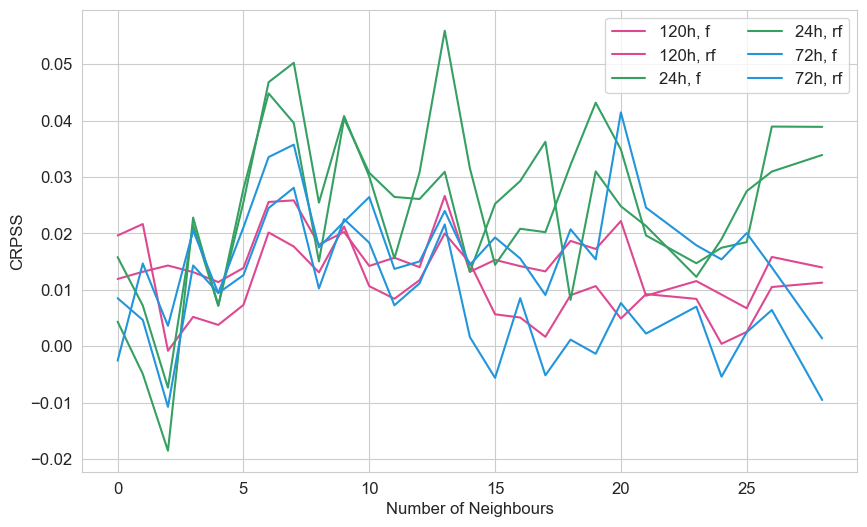

In [24]:
to_plot = res_grouped_station_id.groupby(["dataset", "leadtime", "neighbors"])[["crpss"]].mean().reset_index()
to_plot["dataset_leadtime"] = to_plot["leadtime"] + ", "+ to_plot["dataset"].str.upper()
plt.figure(figsize=(10, 6))
for leadtime in to_plot["leadtime"].unique():
    for dataset in to_plot["dataset"].unique():
        data = to_plot[(to_plot["leadtime"] == leadtime) & (to_plot["dataset"] == dataset)]
        plt.plot(data["neighbors"], data["crpss"], label=f"{leadtime}, {dataset}", c=get_color(leadtime)(0.6))
plt.legend(fontsize=12, ncol=2)
plt.xlabel("Number of Neighbours")
plt.ylabel("CRPSS")

### CRPS vs. Number of Neighbors
Both plots using the GAT and the DRN (DRN does not use neighbors, we take them from the GAT)

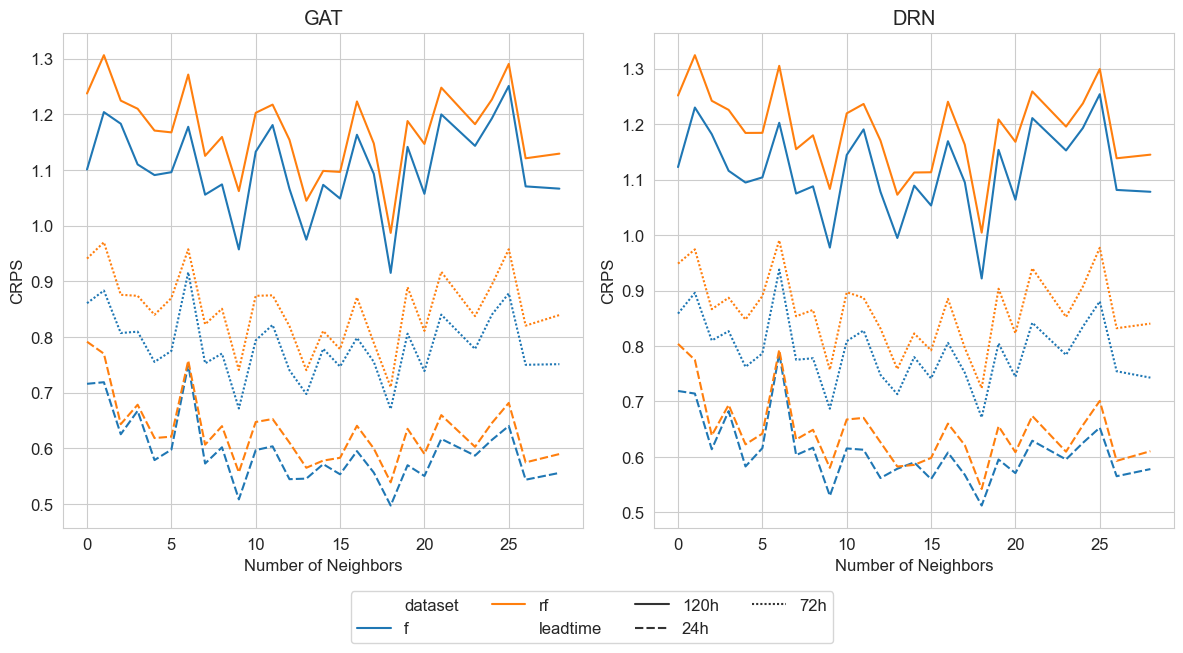

In [25]:
res_grouped = res.groupby(["dataset", "leadtime", "neighbors"])[["crps", "crps_drn"]].mean().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=res_grouped, x="neighbors", y="crps", hue="dataset", style="leadtime", ax=axes[0])
axes[0].set_xlabel("Number of Neighbors")
axes[0].set_ylabel("CRPS")
axes[0].title.set_text("GAT")
axes[0].legend().remove()

sns.lineplot(data=res_grouped, x="neighbors", y="crps_drn", hue="dataset", style="leadtime", ax=axes[1], legend=False)
axes[1].set_xlabel("Number of Neighbors")
axes[1].set_ylabel("CRPS")
axes[1].title.set_text("DRN")

# Add a common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## Diebold-Mariano Test
Statistically test for difference in scores in a stationwise manner. Details in the appendix.

In [26]:
from scipy.stats import norm
def calculate_p_value(t, two_tailed=True):
    if two_tailed:
        p_value = 2 * (1 - norm.cdf(abs(t)))
    else:
        if t > 0:
            p_value = 1 - norm.cdf(t)
        else:
            p_value = norm.cdf(t)
    return p_value

def dm_test(model1, model2, alpha=0.05, LEADTIME="24h", DATASET="f"):
    print("Testing for difference between", model1, "and", model2)
    model1_str = model1
    model2_str = model2

    model1 = pd.read_csv(f"trained_models/{model1}_{LEADTIME}/{DATASET}_results.csv")

    model2 = pd.read_csv(f"trained_models/{model2}_{LEADTIME}/{DATASET}_results.csv")

    dfs = load_dataframes(mode="eval", leadtime=LEADTIME)
    targets = dfs[f"test_{DATASET}"][1].dropna(axis=0) # Needed for Station ID
    
    # Get CRPS per station
    targets.loc[:,"crps_m1"] = crps_no_avg(torch.tensor(model1[["mu", "sigma"]].to_numpy()), torch.tensor(model1["t2m"].to_numpy())).flatten().numpy()
    targets.loc[:,"crps_m2"] = crps_no_avg(torch.tensor(model2[["mu", "sigma"]].to_numpy()), torch.tensor(model2["t2m"].to_numpy())).flatten().numpy()
    
    # get difference between GAT and DRN
    dm_test = targets.groupby("station_id")[["crps_m1", "crps_m2"]].mean()
    
    # Mean of squared differences (sigma squared)
    targets.loc[:,"diff"] = targets["crps_m1"] - targets["crps_m2"]
    targets.loc[:,"diff2"] = targets["diff"]**2
    
    dm_test = targets.groupby("station_id")[["diff2"]].mean()

    # Mean scores
    scores = targets.groupby("station_id")[["crps_m1", "crps_m2"]].mean()
    dm_test = pd.concat([dm_test, scores], axis=1)

    # Number of samples
    dm_test = pd.concat([dm_test, targets.groupby("station_id").size()], axis=1)
    dm_test.rename(columns={0: "n"}, inplace=True)

    # Calculate the test statistic
    dm_test["t"] = (dm_test["n"] ** 0.5) * ((dm_test["crps_m1"] - dm_test["crps_m2"]) / dm_test["diff2"] ** 0.5)

    # Calculate the p-value
    dm_test["p"] = dm_test["t"].apply(calculate_p_value)
    
    # Percent of rejected H0
    print(f"Percent of rejected H0: {(dm_test['p'] < alpha).sum() / len(dm_test)}")

    # Benjamini-Hochberg procedure
    sorted_p_values = dm_test["p"].sort_values().to_numpy()

    bh_threshold = alpha * (np.arange(1, len(sorted_p_values) + 1) / len(sorted_p_values))
    alpha_bh = sorted_p_values[sorted_p_values<=bh_threshold].max()

    print(f"Percent of rejected H0 after Benjamini-Hochberg: {(dm_test['p'] < alpha_bh).sum() / len(dm_test)}")
    
    dm_test["significant"] = dm_test["p"] < alpha_bh
    
    dm_test["in_favor"] = dm_test.apply(lambda x: model1_str if x["t"] < 0 and x["significant"] else model2_str if x["t"] > 0 and x["significant"] else "No difference", axis=1)
    
    res = dm_test["in_favor"].value_counts()/len(dm_test)
    print(res)
    
    return res

In [27]:
pd.options.mode.chained_assignment = None

res = dm_test(model1="drn", model2="best", alpha=0.05, LEADTIME="24h", DATASET="f")

Testing for difference between drn and best
[INFO] Dataframes exist. Will load pandas dataframes.
Percent of rejected H0: 0.425
Percent of rejected H0 after Benjamini-Hochberg: 0.38333333333333336
in_favor
No difference    0.616667
best             0.383333
Name: count, dtype: float64


In [28]:
import itertools
models = ["drn","no_ensemble", "no_edges", "best"]

# Create an empty DataFrame
df = pd.DataFrame(index=models, columns=models)

for model1, model2 in itertools.combinations(models, 2):
    res = dm_test(model1=model1, model2=model2, LEADTIME="120h", DATASET="rf")
    try:
        df.loc[model2, model1] = res[model2]
    except:
        df.loc[model2, model1] = 0
    try:
        df.loc[model1, model2] = res[model1]
    except:
        df.loc[model1, model2] = 0

Testing for difference between drn and no_ensemble
[INFO] Dataframes exist. Will load pandas dataframes.
Percent of rejected H0: 0.21666666666666667
Percent of rejected H0 after Benjamini-Hochberg: 0.06666666666666667
in_favor
No difference    0.933333
no_ensemble      0.050000
drn              0.016667
Name: count, dtype: float64
Testing for difference between drn and no_edges
[INFO] Dataframes exist. Will load pandas dataframes.
Percent of rejected H0: 0.8666666666666667
Percent of rejected H0 after Benjamini-Hochberg: 0.85
in_favor
drn              0.841667
No difference    0.150000
no_edges         0.008333
Name: count, dtype: float64
Testing for difference between drn and best
[INFO] Dataframes exist. Will load pandas dataframes.
Percent of rejected H0: 0.44166666666666665
Percent of rejected H0 after Benjamini-Hochberg: 0.16666666666666666
in_favor
No difference    0.833333
best             0.166667
Name: count, dtype: float64
Testing for difference between no_ensemble and no_edg

In [29]:
(df * 100).round(2)

,drn,no_ensemble,no_edges,best
drn,NaN,1.666667,84.166667,0
no_ensemble,5.0,NaN,89.166667,0
no_edges,0.833333,0.833333,NaN,0
best,16.666667,22.5,97.5,NaN


## Additional results
### Performance in most common temperature range

In [30]:
df = pd.concat([
    pd.read_csv('figures/meanCRPSVsTemp_rf.csv').rename(columns=lambda x: x + '_rf'),
    pd.read_csv('figures/meanCRPSVsTemp_f.csv').drop(columns=["temp"]).rename(columns=lambda x: x + '_f'),
    pd.read_csv('figures/meanSigmaVsTemp_rf.csv').drop(columns=["temp"]).rename(columns=lambda x: x + '_rf'),
    pd.read_csv('figures/meanSigmaVsTemp_f.csv').drop(columns=["temp"]).rename(columns=lambda x: x + '_f')
    ], axis=1)

In [31]:
df[(df["temp_rf"] >= 0) & (df["temp_rf"] <= 15)].mean().round(2)

temp_rf                      7.50
Average_CRPS_best_24h_rf     0.61
Average_CRPS_best_120h_rf    1.11
Average_CRPS_best_72h_rf     0.82
Average_CRPS_best_24h_f      0.58
Average_CRPS_best_72h_f      0.75
Average_CRPS_best_120h_f     1.06
Average_SD_best_72h_rf       1.39
Average_SD_best_24h_rf       0.97
Average_SD_best_120h_rf      1.96
Average_SD_best_120h_f       1.97
Average_SD_best_24h_f        0.97
Average_SD_best_72h_f        1.41
dtype: float64

### Performance of the raw ensemble

In [32]:
df = load_dataframes(mode="eval", leadtime="120h")

[INFO] Dataframes exist. Will load pandas dataframes.


In [33]:
preds = df["test_rf"][0][["number", "station_id", "time","t2m"]]
targets = df["test_rf"][1]
# sort values to ensure right comparison
preds = preds.sort_values(by=["time", "station_id", "number"])
targets = targets.sort_values(by=["time", "station_id"])
# to numpy and reshape
targets_np = targets["t2m"].to_numpy()
preds_np = preds["t2m"].to_numpy().reshape(targets.shape[0],-1)
crps = ens_metrics.ens_crps(obs=targets_np, fcst_ens=preds_np)
crps

/opt/homebrew/Caskroom/miniforge/base/envs/st-gnn/lib/python3.11/site-packages/hydrostats/ens_metrics.py:1328: UserWarning: Row(s) [   62    74    87 ... 89287 89366 89378] contained NaN values and the row(s) have been removed (zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


{'crps': array([0.58717273, 1.70657888, 0.13865049, ..., 4.58838955, 8.85620546,
        8.69566575]),
 'crpsMean': 1.5431564649752556}

In [34]:
PI_range = preds.groupby(["time", "station_id"])["t2m"].agg(["min", "max"]).reset_index()
PI_range["length"] = PI_range["max"] - PI_range["min"]
PI_range = pd.merge(left=PI_range, right=targets, on=["time", "station_id"])
PI_range["hit"] = (PI_range["t2m"] >= PI_range["min"]) & (PI_range["t2m"] <= PI_range["max"])

In [35]:
PI_range["length"].mean()

4.878836

In [36]:
PI_range["hit"].mean()

0.6160400778297139